In [1]:
#!pip install -U datasets seqeval

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import random
import numpy as np
from seqeval.metrics import classification_report, f1_score, accuracy_score
import os
import requests
import zipfile

import torch.nn.functional as F
from torch.utils.data import TensorDataset

In [3]:
seed=42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
dataset = load_dataset("surrey-nlp/PLOD-CW-25")

labels = ["O", "B-AC", "B-LF", "I-LF"]
n_labels = len(labels)
ltoi = {l: i for i, l in enumerate(labels)} # converts labels to indices

In [6]:

from gensim.models import Word2Vec

def extract_sentences_and_labels(dataset_split):
    sentences = []
    labels = []
    for item in dataset_split:
        sentences.append(item['tokens'])   # tokenized sentence
        labels.append(item['ner_tags'])    # corresponding labels
    return sentences, labels

train_sentences, train_labels = extract_sentences_and_labels(dataset['train'])
test_sentences, test_labels = extract_sentences_and_labels(dataset['test'])

train_labels = [[ltoi[label] if isinstance(label, str) else label for label in seq] for seq in train_labels]
test_labels = [[ltoi[label] if isinstance(label, str) else label for label in seq] for seq in test_labels]

# Train Word2Vec on the training sentences
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Build vocabulary and embedding matrix
all_words = set(word for sentence in train_sentences for word in sentence)
vocab = {word: idx + 2 for idx, word in enumerate(all_words)}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

embedding_matrix = np.zeros((len(vocab), 100))
for word, i in vocab.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(100,))


In [7]:
# Prepare input sequences and pad
MAX_LEN = 256
def encode_sentence(sentence):
    ids = [vocab.get(word, 1) for word in sentence]
    return ids[:MAX_LEN] + [0] * (MAX_LEN - len(ids))

def encode_labels(label_seq):
    return label_seq[:MAX_LEN] + [0] * (MAX_LEN - len(label_seq))

X_train = [encode_sentence(sent) for sent in train_sentences]
y_train = [encode_labels(lbls) for lbls in train_labels]
X_test = [encode_sentence(sent) for sent in test_sentences]
y_test = [encode_labels(lbls) for lbls in test_labels]

# Convert to tensors
X_train = torch.tensor(X_train).to(device)
y_train = torch.tensor(y_train).to(device)
X_test = torch.tensor(X_test).to(device)
y_test = torch.tensor(y_test).to(device)

In [8]:
torch.set_float32_matmul_precision("high")

In [9]:
# Define BiLSTM Model
class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_labels, embedding_matrix):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.classifier(x)
        return x

In [10]:
batch_size = 32

# Flattened dataset for random access (emulates get_batch)
train_dataset = list(zip(X_train, y_train))
test_dataset = list(zip(X_test, y_test))

def get_batch(dataset, batch_size):
    ix = torch.randint(len(dataset), (batch_size,))
    x = torch.stack([dataset[i][0] for i in ix]).to(device)
    y = torch.stack([dataset[i][1] for i in ix]).to(device)
    return x, y

import torch.nn.functional as F

@torch.no_grad()
def estimate_loss(model, eval_steps=10):
    out = {}
    model.eval()
    for name, dataset in [("train", train_dataset), ("test", test_dataset)]:
        losses = torch.zeros(eval_steps)
        accuracies = torch.zeros(eval_steps)
        for k in range(eval_steps):
            x, y = get_batch(dataset, batch_size)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y.view(-1), ignore_index=0)
            losses[k] = loss.item()
            
            # Compute accuracy
            preds = torch.argmax(logits, dim=-1)
            mask = (y != 0)
            correct = (preds == y) & mask
            accuracy = correct.sum().item() / mask.sum().item()
            accuracies[k] = accuracy
        
        out[name] = {
            "loss": losses.mean().item(),
            "accuracy": accuracies.mean().item()
        }
    model.train()
    return out

In [11]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def train_model(model, optimizer): 
    model.to(device)
    max_iters = 1000
    eval_interval = 200
    
    # Lists to store metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    eval_steps = []

    lossi = []

    for step in range(max_iters):
        if step % eval_interval == 0:
            metrics = estimate_loss(model)
            
            train_losses.append(metrics['train']['loss'])
            test_losses.append(metrics['test']['loss'])
            train_accuracies.append(metrics['train']['accuracy'])
            test_accuracies.append(metrics['test']['accuracy'])
            eval_steps.append(step)

            print(
                f"Step {step}: "
                f"Train loss {metrics['train']['loss']:.4f}, accuracy {metrics['train']['accuracy']:.4f} | "
                f"Test loss {metrics['test']['loss']:.4f}, accuracy {metrics['test']['accuracy']:.4f}"
            )
        
        xb, yb = get_batch(train_dataset, batch_size)
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16):
            logits = model(xb)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), yb.view(-1), ignore_index=0)
        
        lossi.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Plotting losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(eval_steps, train_losses, label="Train Loss")
    plt.plot(eval_steps, test_losses, label="Test Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Loss over Time")
    plt.legend()
    plt.grid(True)

    # Plotting accuracies
    plt.subplot(1, 2, 2)
    plt.plot(eval_steps, train_accuracies, label="Train Accuracy")
    plt.plot(eval_steps, test_accuracies, label="Test Accuracy")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Time")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return model


In [12]:
def evaluate_model(model):
    # Evaluation
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        pred_labels = torch.argmax(predictions, dim=2).cpu().numpy()
    
    true_labels = y_test.cpu().numpy()
    
    # Format for evaluation
    true_str = []
    pred_str = []
    for t_seq, p_seq in zip(true_labels, pred_labels):
        temp_true = []
        temp_pred = []
        for t, p in zip(t_seq, p_seq):
            if t != 0:
                temp_true.append(labels[t])
                temp_pred.append(labels[p])
        true_str.append(temp_true)
        pred_str.append(temp_pred)
    
    # Detailed evaluation report
    print("Classification Report:\n")
    print(classification_report(true_str, pred_str))
    print("F1 Score:", f1_score(true_str, pred_str))
    print("Accuracy:", accuracy_score(true_str, pred_str))

    flat_true = [ltoi[l] for seq in true_str for l in seq]
    flat_pred = [ltoi[l] for seq in pred_str for l in seq]

    cm = confusion_matrix(flat_true, flat_pred, labels=list(range(len(labels))))
    fig, ax = plt.subplots(figsize=(8, 6))  # <-- Adjust size here
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

Step 0: Train loss 1.3911, accuracy 0.2006 | Test loss 1.3905, accuracy 0.2104
Step 200: Train loss 0.5151, accuracy 0.8082 | Test loss 0.5110, accuracy 0.7956
Step 400: Train loss 0.2479, accuracy 0.9173 | Test loss 0.3104, accuracy 0.8851
Step 600: Train loss 0.0979, accuracy 0.9728 | Test loss 0.3883, accuracy 0.8500
Step 800: Train loss 0.0460, accuracy 0.9897 | Test loss 0.3526, accuracy 0.8775


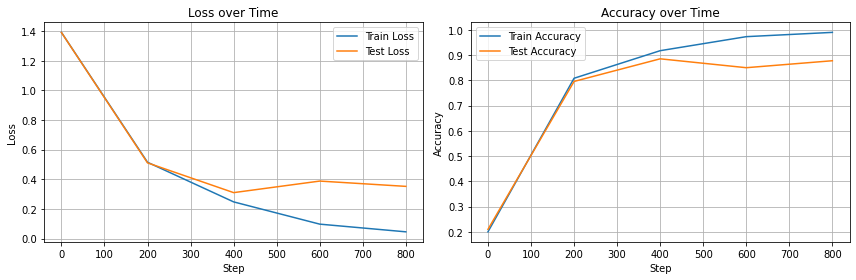

Classification Report:

              precision    recall  f1-score   support

          AC       0.82      0.95      0.88       797
          LF       0.51      0.67      0.58       482

   micro avg       0.69      0.85      0.76      1279
   macro avg       0.66      0.81      0.73      1279
weighted avg       0.70      0.85      0.77      1279

F1 Score: 0.76224022543149
Accuracy: 0.8499600957701516


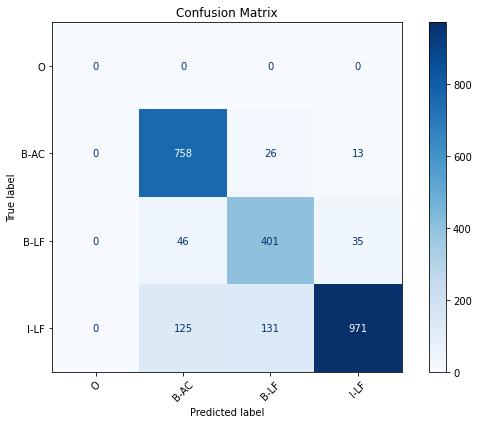

In [13]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.4229, accuracy 0.3082 | Test loss 1.4224, accuracy 0.2988
Step 200: Train loss 0.7282, accuracy 0.7504 | Test loss 0.7371, accuracy 0.7319
Step 400: Train loss 0.5738, accuracy 0.7820 | Test loss 0.5757, accuracy 0.7732
Step 600: Train loss 0.4441, accuracy 0.8382 | Test loss 0.4533, accuracy 0.8227
Step 800: Train loss 0.3670, accuracy 0.8700 | Test loss 0.3988, accuracy 0.8434


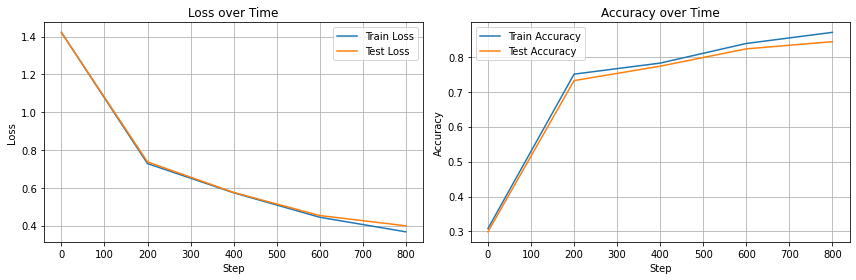

Classification Report:

              precision    recall  f1-score   support

          AC       0.78      0.95      0.86       797
          LF       0.57      0.68      0.62       482

   micro avg       0.70      0.85      0.77      1279
   macro avg       0.68      0.81      0.74      1279
weighted avg       0.70      0.85      0.77      1279

F1 Score: 0.7690120824449181
Accuracy: 0.8451715881883479


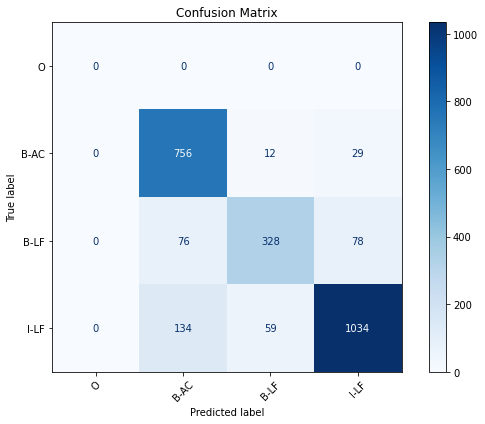

In [14]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.4382, accuracy 0.0902 | Test loss 1.4375, accuracy 0.1866
Step 200: Train loss 1.3098, accuracy 0.4232 | Test loss 1.3059, accuracy 0.4016
Step 400: Train loss 1.2310, accuracy 0.4739 | Test loss 1.2211, accuracy 0.4751
Step 600: Train loss 1.1735, accuracy 0.5033 | Test loss 1.1697, accuracy 0.4759
Step 800: Train loss 1.1468, accuracy 0.4711 | Test loss 1.1378, accuracy 0.4823


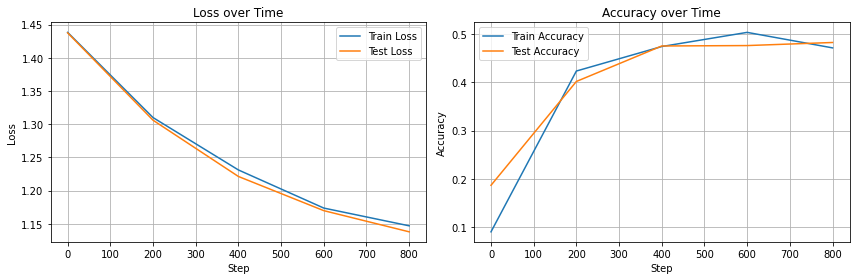

Classification Report:

              precision    recall  f1-score   support

          AC       0.00      0.00      0.00       797
          LF       0.00      0.00      0.00       482

   micro avg       0.00      0.00      0.00      1279
   macro avg       0.00      0.00      0.00      1279
weighted avg       0.00      0.00      0.00      1279

F1 Score: 0.0013046314416177431
Accuracy: 0.48842777334397447


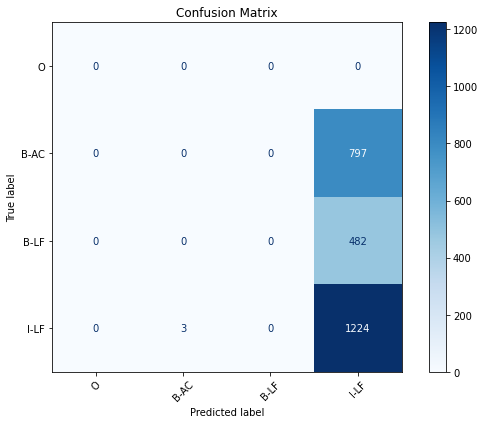

In [15]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=0.0003)
model = train_model(model, optimizer)
evaluate_model(model)

Step 0: Train loss 1.3714, accuracy 0.1970 | Test loss 1.3682, accuracy 0.1985
Step 200: Train loss 0.6707, accuracy 0.7538 | Test loss 0.6674, accuracy 0.7439
Step 400: Train loss 0.6120, accuracy 0.7640 | Test loss 0.5785, accuracy 0.7697
Step 600: Train loss 0.5393, accuracy 0.7859 | Test loss 0.5635, accuracy 0.7797
Step 800: Train loss 0.5163, accuracy 0.7975 | Test loss 0.5025, accuracy 0.8064


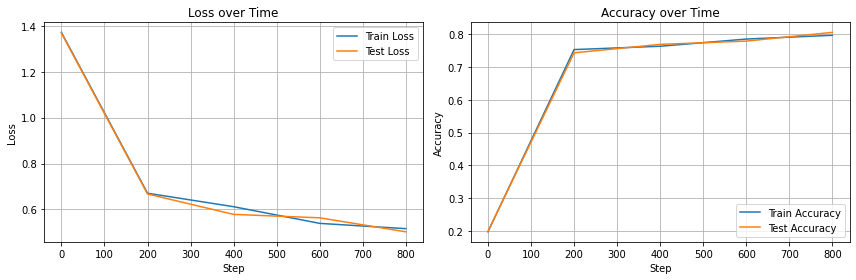

Classification Report:

              precision    recall  f1-score   support

          AC       0.81      0.89      0.84       797
          LF       0.50      0.66      0.57       482

   micro avg       0.68      0.80      0.73      1279
   macro avg       0.65      0.77      0.71      1279
weighted avg       0.69      0.80      0.74      1279

F1 Score: 0.732737030411449
Accuracy: 0.8212290502793296


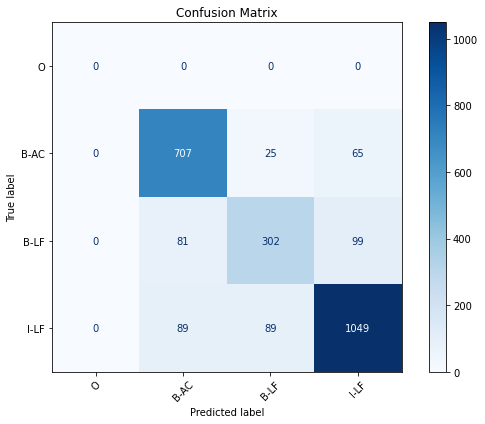

In [16]:
model = BiLSTM_NER(len(vocab), 100, 128, n_labels, embedding_matrix)
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=0.001)
model = train_model(model, optimizer)
evaluate_model(model)